# Preprocessing

First take a look at the data

In [ ]:
import pandas as pd
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import plotly.graph_objects as go
import sklearn
import sklearn.compose
import sklearn.preprocessing
import sklearn.model_selection
from pandas.api.types import is_object_dtype

In [ ]:
csv_data = pd.read_csv('immo_dev_data.csv')

# display data transposed, easier to see all columns
csv_data.head().T

,0,1,2,3,4
Id,7135329,7170979,7172246,7172252,7172733
AreaLiving,140,143,160,351,400
AreaProperty,501,277,712,496,1800
BuiltYear,2016,2004,1945,2016,1975
FloorNumber,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...
gde_workers_sector3,358,2787,1138,17,701
gde_workers_total,537,5041,2999,39,732
location_has_street,0,1,0,0,0
location_is_complete,0,1,0,0,0


# 

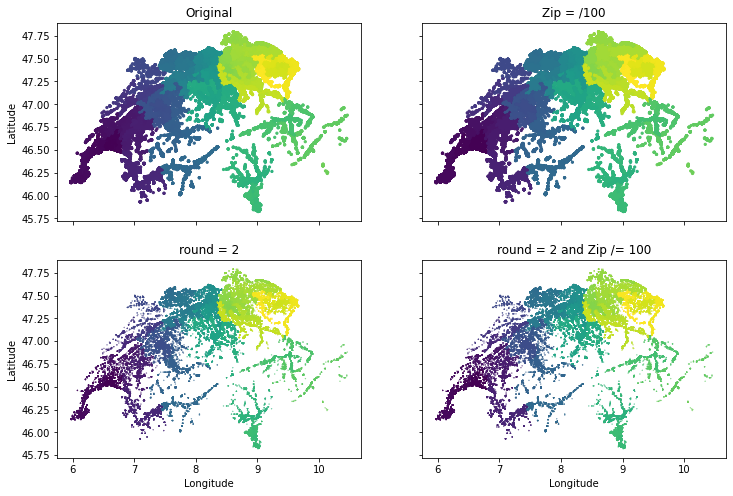

In [ ]:
fig, axs = plt.subplots(2, 2, figsize = (12, 8))
axs[0, 0].scatter(csv_data['Longitude'], csv_data['Latitude'], c = csv_data['Zip'], s = 5)
axs[0, 0].set_title('Original')
axs[0, 1].scatter(csv_data['Longitude'], csv_data['Latitude'], c = (csv_data['Zip'] / 100).astype('int64'), s = 5)
axs[0, 1].set_title('Zip = /100')
axs[1, 0].scatter(csv_data['Longitude'].round(decimals = 2), csv_data['Latitude'].round(decimals = 2), c = csv_data['Zip'], s = 0.1)
axs[1, 0].set_title('round = 2')
axs[1, 1].scatter(csv_data['Longitude'].round(decimals = 2), csv_data['Latitude'].round(decimals = 2), c = (csv_data['Zip'] / 100).astype('int64'), s = 0.1)
axs[1, 1].set_title('round = 2 and Zip /= 100')

for ax in axs.flat:
    ax.set(xlabel='Longitude', ylabel='Latitude')

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()

# One Hot Encoding

In [ ]:
class preprocessor:
    def __init__(self, df, y_var, cols_to_drop = []):
        self.y = df[y_var].copy()
        cols_to_drop.append(y_var)
        print('Columns dropped to create X: ', cols_to_drop)
        if len(cols_to_drop) == 1:
            self.X = df.drop(columns = [y_var])
        else:
            self.X = df.drop(columns = cols_to_drop)
        self.enc = sklearn.preprocessing.OneHotEncoder(handle_unknown='ignore')
        self.scaler = sklearn.preprocessing.StandardScaler(with_std=False)
    

    def __fillna(self, _df):
        df = _df.copy()
        for col in df:
            #get dtype for column
            dt = df[col].dtype
            #check if it is a number
            if is_object_dtype(dt):
                df[col] = df[col].fillna("No Entry")
            else:
                df[col] = df[col].fillna(-1)
        return df


    def __fit_df(self):
        """
        This function fits (one hot encoding) the categorical columns if they are of type object and
        function fits (standardscaler) the numerical columns if they are of numbers (based on select_dtypes).
        Takes:
        - _df: pandas.DataFrame
        - enc: sklearn.preprocessing.OneHotEncoder(handle_unknown='ignore') object

        returns:
        - encoded df as numpy.array
        """
        # Fit for onehot-encoder
        df_obj = self.X_train_df.select_dtypes(include = [object])
        self.enc.fit(df_obj)
        
        # Fit for standard scaler:
        df_num = self.X_train_df.select_dtypes(include = 'number')
        self.std = df_num.std(axis=0).fillna(1)
        self.mean = df_num.mean(axis=0).fillna(0)

    def __encode_transform_df(self, _df):
        """
        This function transforms the new df with the fitted encoder (one hot encoding).

        Takes:
        - _df: pandas.DataFrame
        - enc: sklearn.preprocessing.OneHotEncoder(handle_unknown='ignore') object

        returns:
        - transformed df as numpy.array
        """

        df = _df.copy()
        df_obj = df.select_dtypes(include = [object])
        df.drop(columns = df_obj.columns, inplace=True)
        return np.concatenate((df.to_numpy(), self.enc.transform(df_obj).toarray()), axis = 1)
        

    def __standardise_df(self, _df):
        """
        This function transforms the new df with the fitted encoder (one hot encoding).

        Takes:
        - _df: pandas.DataFrame
        - enc: sklearn.preprocessing.OneHotEncoder(handle_unknown='ignore') object

        returns:
        - transformed df as numpy.array
        """
        df = _df.copy()
        df_num = df.select_dtypes(include = 'number')
        df.drop(columns = df_num.columns, inplace=True)
        df_num = ((df_num - self.mean) / (self.std)).copy()
        df = df.join(df_num)
        return df


    def split_X_y(self, test_frac = 0.2):
        self.X_test_df = self.X.sample(frac = test_frac)
        self.X_train_df = self.X.drop(index = self.X_test_df.index, axis = 0)
        self.y_train_df = self.y.iloc[self.X_train_df.index]
        self.y_test_df = self.y.iloc[self.X_test_df.index]

    def encode_sample(self, _sample):
        sample = _sample.copy()
        sample = self.__standardise_df(sample)
        sample = self.__fillna(sample)
        sample = self.__encode_transform_df(sample)
        return sample

    def preprocess(self):
        self.split_X_y()
        self.__fit_df()
        self.X_train_df = self.__fillna(self.X_train_df).copy()
        self.X_train_df = self.__standardise_df(self.X_train_df).copy()
        self.X_train = self.__encode_transform_df(self.X_train_df).copy()
        self.X_test = self.encode_sample(self.X_test_df)

In [ ]:
preprocessor = preprocessor(csv_data.head(5000), y_var='PurchasePrice', cols_to_drop=['StreetAndNr', 'Id'])

Columns dropped to create X:  ['StreetAndNr', 'Id', 'PurchasePrice']


In [ ]:
preprocessor.preprocess()

In [ ]:
preprocessor.X_train

array([[True, -0.6421675445360506, -0.43837640339749767, ..., 0.0, 0.0,
        0.0],
       [True, -0.5991596448203756, -0.8182976049416123, ..., 0.0, 0.0,
        0.0],
       [True, -0.3554482130982171, -0.08050420015728257, ..., 0.0, 0.0,
        0.0],
       ...,
       [True, -1.0005667088333425, 0.02634863777699966, ..., 1.0, 0.0,
        0.0],
       [True, 0.47603784807150024, 0.16203478118561201, ..., 0.0, 0.0,
        0.0],
       [True, 1.508227441247701, -0.2619844169663016, ..., 0.0, 0.0, 0.0]],
      dtype=object)